<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy.fft import fftfreq

In [39]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [40]:
# get historical market data
hist = cat.history(period="max")

In [41]:
hist = hist["Open"].to_frame()

In [42]:
# Convert the index from timestamp to date
hist = hist.reset_index()
hist["Date"] = hist["Date"].dt.date
hist = hist.set_index("Date")

<Axes: xlabel='Date'>

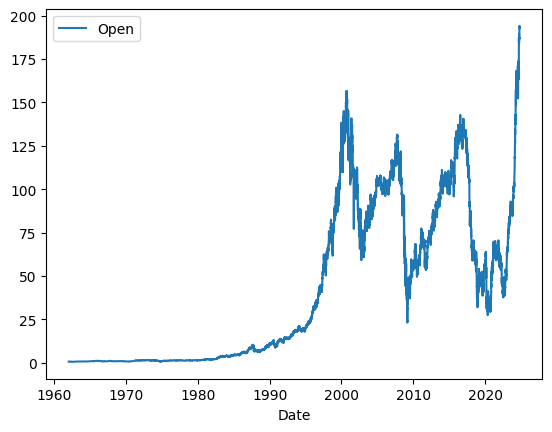

In [43]:
hist.reset_index().plot(x="Date",y="Open")

## Imputing Missing Values
For some timesteps some values may be missing therefore we impute cnsidering the last not-null value

In [44]:
# Check if all the data points are equally spaced

beginning_timestamp = hist.index.min()
last_timestamp = hist.index.max()
delta_t = hist.index[1] - beginning_timestamp


equispaced_index = pd.date_range(start = beginning_timestamp,
              end = last_timestamp,
              freq = delta_t
)

equispaced_df = pd.DataFrame(index = equispaced_index,
             data = {"test_col" : np.zeros(equispaced_index.size)}
).reset_index()


equispaced_df["index"] = equispaced_df["index"].dt.date

hist = equispaced_df.merge(hist.reset_index(),
                    how='left',
                    left_on = 'index',
                    right_on='Date'
)

cols = ["index", "Open"]

hist = hist[cols]

In [45]:
# Imputing the nulls with the last non null value

nulls_indices = hist[hist["Open"].isna()].index.copy()

for idx in nulls_indices:

  if idx == 0:
    hist.iloc[(idx, 1)] = 0.0
  elif idx >= 1:
    hist.iloc[(idx, 1)] = hist.iloc[(idx - 1, 1)]

hist.rename(columns={"index": "Date"}, inplace=True)

hist = hist.set_index("Date")

In [46]:
hist.describe()

,Open
count,22939.000000
mean,41.653223
std,45.519579
min,0.468906
25%,1.396494
50%,17.715058
75%,79.441894
max,194.089996


## Moving Average Derivation

Suppose we have a time series:

\begin{align}
x_t \hspace{2cm} t=0,1,..,T-1
\end{align}


And its cumulative sum:

\begin{align}
c_t = \sum_{i=0}^t x_i
\end{align}

And we want to compute the moving average at time step $t$, by considering the $w$ previous time steps ($t$ is also included):

\begin{align}
\overline{x}_t = \frac{1}{w} \sum_{i = t-w+1}^t x_i \hspace{2cm} \, for \, t = w-1,...,T-1.
\end{align}

The cumulative sum at time $t$ can be written as:

\begin{align}
c_t = \sum_{i=0}^t x_i = \sum_{i=0}^{t-w} x_i \, + \, \sum_{i=t-w+1}^{t} x_i = c_{t-w} \, + \, w\, \overline{x}_t
\end{align}

The previous formula is defined for $t=w,...,T-1$ as can be seen by inspecting the upper extreme of the first sum and considering that $x_t$ is definited for $t\ge0$, therefore:

\begin{align}
\overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{align}

To find $\overline{x}_t$ at time $t=w-1$ we use the definition:

\begin{align}
\overline{x}_{w-1} = \frac{1}{w} \sum_{i = (w-1)-w+1}^{w-1} x_i = \frac{1}{w} \sum_{i = 0}^{w-1} x_i = \frac{1}{w} c_{w-1}.
\end{align}

Overall, the moving average can be computed via:

\begin{cases}
      \overline{x}_{w-1} = \frac{1}{w} c_{w-1}\\
      \overline{x}_t = \frac{1}{w}(c_t - c_{t-w}) \hspace{2cm} t=w,...,T-1.
\end{cases}


### Algorithm definition

If we want to use a unique array called mov we can implement the following algorithm:

1. Define variable **mov** as the cumulative average.
2. Modify the elemnts of the array mov from the index $w$ by using
   the difference:
   
   **mov[w:] = mov[w:] - mov[:-w]**

3. Note that mov[w-1] has still the initial value equal to the
   cumulative sum at $t=w-1$ therefore we return the array:

   **(1/w)  mov[w-1:]**


This algorithm is implemented in the function moving_average_forecast:

In [47]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)

  # This is necessary because to subtract two pandas series it is necessary
  # That both series have the same index. Therefore we force the series
  # mov[window_size:] and mov[:-window_size] to have the same index

  index = pd.Index(
      list(
          range(mov.size - window_size)
      )
  )

  mov[window_size:] = mov[window_size:].set_axis(index)- mov[:-window_size].set_axis(index)

  return mov[window_size - 1:] / window_size

In [48]:
window_size = 1

mov_average_col = "Open_mov_avg"
hist[mov_average_col] = moving_average_forecast(hist["Open"], window_size)

<Axes: xlabel='Date'>

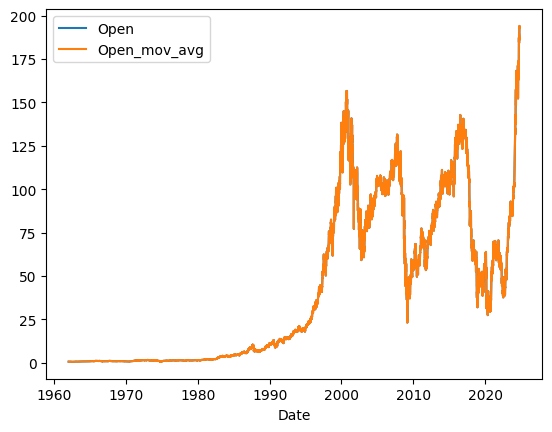

In [49]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_mov_avg"])

### First Difference

The first difference is defined as:
$d_t = x_t - x_{t-q} \hspace{2cm} t=q,..., T-1$

Therefore it can be implemenentate in the function diff_series following the algoritm:

1. Define the original series as the variable **series**

2. Return the difference **series[q:] - series[:-q]**

In [50]:
def diff_series(series, q):
  original_index = series.index.copy()

  # saving te first q values in cae we want to recnstruct te original
  # series
  first_q_values = series[:q].to_numpy(copy=True)

  # Removal of the first t0-1 indices
  original_index = original_index.delete(list(range(q)))

  # conversion into numpy array to avoid indices mismatches
  series = series[q:].to_numpy(copy=True) - series[:-q].to_numpy(copy=True)

  # Returning the final pandas series from the previous numpy array
  return pd.Series(series, index=original_index), first_q_values, original_index

In [51]:
hist["Open_diff"], first_q_values, original_index =  diff_series(hist["Open"], 3)

<Axes: xlabel='Date'>

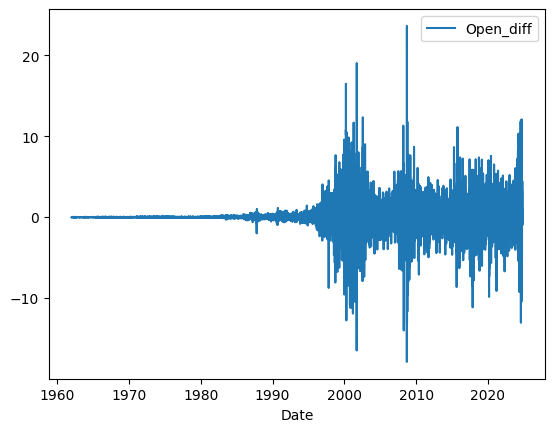

In [52]:
hist.reset_index().plot(x="Date", y="Open_diff")

### Series Integration

In order to reconstruct the original series from the differenced one we consider the first difference written for te first term of te original series as:

$x_{t_0+q}=  x_{t_0} + d_{t_0+q} \hspace{1cm} t_0=0, ...,q-1$

$x_{t_0+2q}=  x_{t_0 + q} + d_{t_0+2q} \hspace{1cm} t_0=0, ...,q-1$

Therefore:

$x_{t_0+2q}=  x_{t_0} + d_{t_0+q} + d_{t_0+2q} \hspace{1cm} t_0=0, ...,q-1$

Reasoning by induction we find then:

$x_{t_0+nq}=  x_{t_0} + \sum_{k=1}^n d_{t_0+kq}  \hspace{1cm} t_0=0, ...,q-1$

if we definw the $q$ subseries:

$d^0 = d_{t_0 + kq}  \hspace{1cm} k=1,...,n$ we apply cumulative sum and add $x_{t_0}$ we find the subseries $x_{t_0+nq}$. All the $q$ subseries (obtained by changing $t_0$) can be then used to reconstruct the full original series $x_t$.


In [53]:
def integrate_series(first_q_values, series):

  """Function to reconstruct a differenced time series given the first
     q  values of the original series"""

  original_index = series.index

  q = first_q_values.size
  T = series.size

  # Creation of an annay of zeros with the final size of the time series
  result = np.zeros(shape= T)

  # Restablishing the first q values of the original series
  result[:q] = first_q_values

  # Creation of the q subseries
  for t0 in range(q):
    sub_series = series[t0+q::q].to_numpy()

    sub_series = first_q_values[t0] + np.cumsum(sub_series)

    # Population of the subseries
    for k in range(len(sub_series)):
      result[t0 + (k+1)*q] = sub_series[k]

  return pd.Series(result, index = original_index)

In [54]:
hist["Open_diff_integrated"] = integrate_series(first_q_values, hist["Open_diff"])

<Axes: xlabel='Date'>

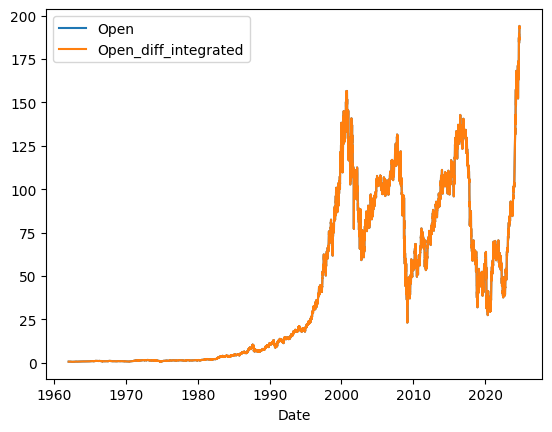

In [55]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_diff_integrated"])

## Training and Validation Test Split

In [56]:
number_time_steps = hist.shape[0]
train_perc = 80.0
train_index = int(np.floor(number_time_steps * train_perc/100.0))

train_set = hist.iloc[:train_index]
val_set = hist.iloc[train_index:]

## Naive Forecast

Naive forecast predicts value at time $t+1$ as equal to the value of the series at time $t$. This will be our baseline model to evaluate all the models against it. Note that naive forecast $\hat{x}_{t+1}$ is equivalent to moving average $\overline{x}_t$ at time $t$ with $w=1$ in fact:

\begin{align}
\hat{x}_{t+1} \approx \overline{x}_t = \frac{1}{1} \sum_{i = t-1+1}^t x_i = \sum_{i = t}^t x_i = x_{t}
\end{align}


In [57]:
data_one_time_tep_before = hist["Open"][train_index - 1:-1].values

val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )

<ipython-input-57-c56b9a4f2e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )


<Axes: xlabel='Date'>

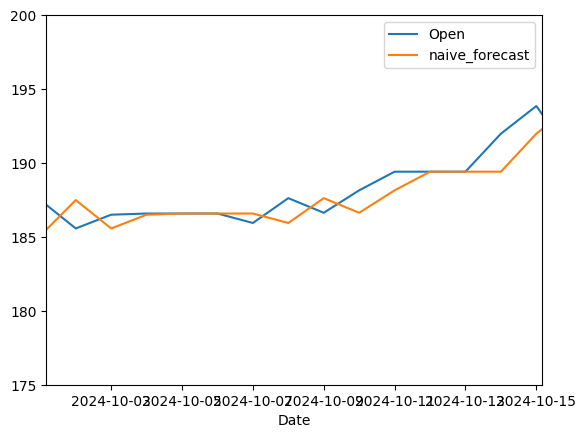

In [58]:
val_set.reset_index().plot(x="Date",
                           y=["Open", "naive_forecast"],
                           xlim = ('2024-10-01 00:00:00-04:00', '2024-10-15 00:00:00-04:00'),
                           ylim = (175, 200))

In [59]:
errors = val_set["Open"] - val_set["naive_forecast"]
abs_errors = np.abs(errors)
MAE = abs_errors.mean()
print(f"The Mean Absolute Error (MAE) for the naive forecast is {MAE}")

The Mean Absolute Error (MAE) for the naive forecast is 0.6943676361470549


## Moving Average Forecast

### Fourier Transform
Fourier transform and Power Spectral Density (PSD) are used to find seasonality in the timeseries. The frequencies of seasonality may be identifying by peaks in the PSD.

In [60]:
from scipy.fft import fft, ifft

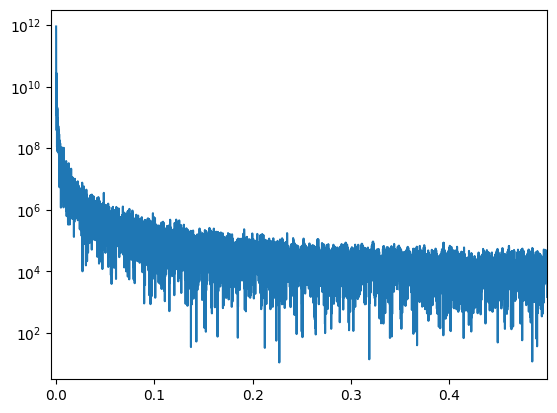

In [61]:
# Number of time steps
N = equispaced_index.size

# frequencies in cycles/delta_t. Only the positive frequencies are taken
# because the function is real and the FFT is symmetric
frequencies = fftfreq(N, d = 1)[:N//2]

# Discrete Fourier Transform computation. Only te values with Re[ft] >= 0 are taken
ft = fft(hist["Open"].values)[:N//2]

max_frequency = np.max(frequencies)

# POwer Spectral Density (fft^2)
psd = np.square(np.abs(ft))

import matplotlib.pyplot as plt

plt.xlim(-0.005,max_frequency)

plt.yscale("log")
plt.plot(frequencies, psd)

Therefore there is no seasonality in the time series. Let's consider the moving average in the validation set with varying window size :

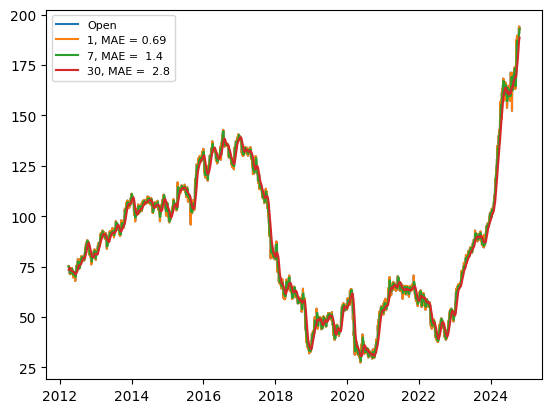

In [62]:
windows = [1, 7, 30]

true_val = val_set["Open"]


plt.plot(val_set.index, true_val, label = "Open")

for w in windows:

  mov_val = moving_average_forecast(hist["Open"][train_index - w:], w)
  pred_val_index = mov_val.index + delta_t
  pred_val = pd.Series(mov_val.values, index = pred_val_index)[:-1]

  errors = true_val - pred_val
  abs_errors = np.abs(errors)
  MAE = abs_errors.mean()

  label = f"{str(w)}, MAE = {MAE:{4}.{2}}"

  plt.plot(mov_val.index, mov_val, label = label)

plt.legend(loc="upper left")
plt.legend(fontsize = 8.0)
plt.show()

## Machine Learning

### Time Window

We want to forecast the next value of a time series using a time window made of the previous $n_w$ time steps. Each time window will have an initial time represented by the second time instant of the preceding window. For example for window $j$ and $j+1$ we will have:

\begin{aligned}
window_j: \hspace{2cm} t_j, t_{j+1}, ... , t_{j+n_w-1}, \\
window_{j+1}: \hspace{2cm} {t_{j+1}}, t_{j+2}, ... , t_{j+n_w}
\end{aligned}

In order to train a supervised machine learning model we need a label for each training sample. In this case, we will have that for each window the first $n_{w-1}$ time steps represents the training sample while the last time step $t_{n_w}$ represents the target to predict.


In [63]:
import tensorflow as tf

In [64]:
train_set = train_set.reset_index()["Open"]

In [65]:
# Creation of a tensorflow dataset from list
train_set = tf.data.Dataset.from_tensor_slices(train_set.values)

In [66]:
samples_per_window = 5
# Shift used to make a window starting with the second time step of the previous
# window
# Drop Remainder is used to obtain all windows with an equal number of samples_per_window
# Beacuse ML models expect same number of training examples in each window
train_set = train_set.window(size=samples_per_window, shift=1, drop_remainder=True)

# Storing te numer of windows into a variable used later to shaffle
# the dataset
number_of_windows = tf.data.experimental.cardinality(train_set).numpy()

In [67]:
# Printing the structure of the windows for the first
# five windows to check data
for idx, window in enumerate(train_set.take(5)):
  string = f"WINDOW {idx}: "
  for elem in window:
    string += f"{str(elem.numpy())[:8]} "

  print(string)

WINDOW 0: 0.624761 0.619554 0.616431 0.609142 0.609142 
WINDOW 1: 0.619554 0.616431 0.609142 0.609142 0.609142 
WINDOW 2: 0.616431 0.609142 0.609142 0.609142 0.593523 
WINDOW 3: 0.609142 0.609142 0.609142 0.593523 0.592482 
WINDOW 4: 0.609142 0.609142 0.593523 0.592482 0.595606 


In [68]:
# Conversion of each window into a tensor.
# The batch method takes a number of samples_per_window and create a tensor
# The falt_map method run a function on a each dataset part of a nested
# dataset

train_set = train_set.flat_map(lambda window: window.batch(samples_per_window))

In [69]:
# Printing the tensors that constitute the dataset
for idx, window in enumerate(train_set.take(5)):
  print(f"TENSOR {idx}: {window.numpy()}")

TENSOR 0: [0.62476171 0.61955491 0.61643116 0.60914216 0.60914216]
TENSOR 1: [0.61955491 0.61643116 0.60914216 0.60914216 0.60914216]
TENSOR 2: [0.61643116 0.60914216 0.60914216 0.60914216 0.59352338]
TENSOR 3: [0.60914216 0.60914216 0.60914216 0.59352338 0.59248237]
TENSOR 4: [0.60914216 0.60914216 0.59352338 0.59248237 0.59560611]


In [70]:
# We split each tensor into two tensors one representing the input features and
# the other the representing the target. The map method maps each tensor, part of
# the dataset into a couple of tensors. The first tensor has the first samples_per_window -1
# samples while the last has only the last sample

train_set = train_set.map(lambda window: (window[:-1], window[-1:]))

In [71]:
for input_sample, target_sample in train_set.take(5):
  print(f"INPUT SAMPLE: {input_sample.numpy()} ", f"TARGET: {target_sample.numpy()}")

INPUT SAMPLE: [0.62476171 0.61955491 0.61643116 0.60914216]  TARGET: [0.60914216]
INPUT SAMPLE: [0.61955491 0.61643116 0.60914216 0.60914216]  TARGET: [0.60914216]
INPUT SAMPLE: [0.61643116 0.60914216 0.60914216 0.60914216]  TARGET: [0.59352338]
INPUT SAMPLE: [0.60914216 0.60914216 0.60914216 0.59352338]  TARGET: [0.59248237]
INPUT SAMPLE: [0.60914216 0.60914216 0.59352338 0.59248237]  TARGET: [0.59560611]


In [75]:
# When a ML model is trained it is necessary that the samples are
# Independent and and Identically Distributed (IID)
# IID can be guaranteed by shuffllying the dataset
# therefore the order of the windows in the dataset changes but the structure
# of each window remains the same

train_set = train_set.shuffle(buffer_size = number_of_windows)

In [76]:
# Showing the shuffled dataset
for input_sample, target_sample in train_set.take(5):
  print(f"INPUT SAMPLE: {input_sample.numpy()} ", f"TARGET: {target_sample.numpy()}")

INPUT SAMPLE: [3.77899837 3.78797545 3.78797545 3.7879736 ]  TARGET: [3.74309191]
INPUT SAMPLE: [114.03769556 114.03769556 109.90274906 113.16719832]  TARGET: [113.43926224]
INPUT SAMPLE: [34.62082972 34.62082972 34.62082972 34.62082972]  TARGET: [34.87728227]
INPUT SAMPLE: [18.9998625  19.19104856 19.4539461  19.4539461 ]  TARGET: [19.4539461]
INPUT SAMPLE: [22.8345933  22.78462649 22.78462649 22.63472195]  TARGET: [22.44930634]


In [77]:
windows_per_batch = 2

# Creating mini batches of windows_per_batch
train_set = train_set.batch(windows_per_batch).prefetch(1)

In [85]:
for idx, (X_train, Y_train) in enumerate(train_set.take(5)):
  print(f"BATCH {idx}:\nX_train={X_train.numpy()}, Y_train={Y_train.numpy()}")


BATCH 0:
X_train=[[101.34703117 101.03031917 100.82875887 102.15318521]
 [ 65.27728988  65.27728988  65.27728988  65.96608052]], Y_train=[[101.98043981]
 [ 65.33025477]]
BATCH 1:
X_train=[[ 9.36111864  9.57881759  9.57881759  9.57881759]
 [66.22940667 67.04750743 67.04750743 67.04750743]], Y_train=[[ 9.51944257]
 [67.04750743]]
BATCH 2:
X_train=[[1.01906795 1.02134848 1.02134848 1.02134848]
 [1.05134753 1.05134753 1.04412176 1.041713  ]], Y_train=[[1.02134866]
 [1.04171371]]
BATCH 3:
X_train=[[0.76407716 0.76075959 0.7607601  0.75744259]
 [2.92131998 2.99298234 3.07729225 3.11523018]], Y_train=[[0.75744259]
 [3.08150699]]
BATCH 4:
X_train=[[ 0.83402828  0.84140858  0.85124942  0.85124942]
 [49.3068248  50.14019422 49.58462648 52.01521726]], Y_train=[[ 0.85616973]
 [52.01521726]]
